In [1]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline
import tensorflow as tf
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("chest_xray"))

Using TensorFlow backend.


['.DS_Store', 'test', 'train', 'val']


In [2]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [3]:
# with tf.device('/device:GPU:0'):
# # Creates a graph.
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)
# # Creates a session with log_device_placement set to True.
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# # Runs the op.
# print(sess.run(a))
# print(a)

In [4]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [7]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
# pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
bacteria_cases = pneumonia_cases_dir.glob('*_bacteria_*.jpeg')
virus_cases = pneumonia_cases_dir.glob('*_virus_*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))
# Go through all the bacteria cases. The label for these cases will be 1
for img in bacteria_cases:
    train_data.append((img, 1))
# Go through all the virus cases. The label for these cases will be 2
for img in virus_cases:
    train_data.append((img, 2))
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\val\PNEUMONIA\person1949_bacteria_4...,1
1,chest_xray\val\PNEUMONIA\person1954_bacteria_4...,1
2,chest_xray\val\PNEUMONIA\person1952_bacteria_4...,1
3,chest_xray\val\NORMAL\NORMAL2-IM-1438-0001.jpeg,0
4,chest_xray\val\NORMAL\NORMAL2-IM-1430-0001.jpeg,0


1    8
0    8
Name: label, dtype: int64


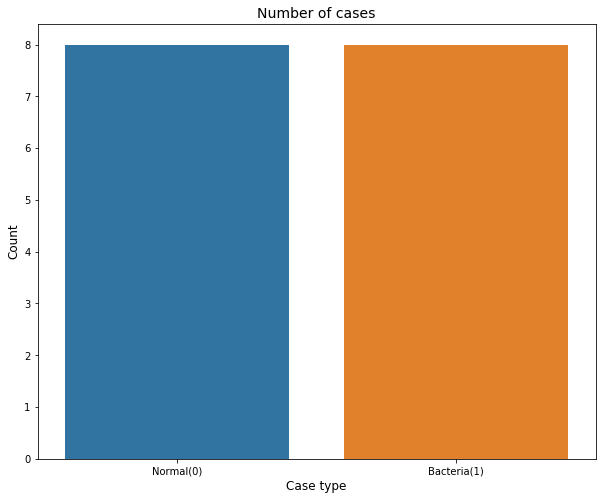

In [8]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Bacteria(1)', 'Virus(2)'])
plt.show()

In [5]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL1'
pneumonia_cases_dir = train_dir / 'PNEUMONIA1'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
# pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
bacteria_cases = pneumonia_cases_dir.glob('*_bacteria_*.jpeg')
virus_cases = pneumonia_cases_dir.glob('*_virus_*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))
# Go through all the bacteria cases. The label for these cases will be 1
for img in bacteria_cases:
    train_data.append((img, 1))
# Go through all the virus cases. The label for these cases will be 2
for img in virus_cases:
    train_data.append((img, 2))
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\train\NORMAL1\NORMAL2-IM-0454-0001....,0
1,chest_xray\train\NORMAL1\NORMAL2-IM-1252-0001....,0
2,chest_xray\train\PNEUMONIA1\person1096_bacteri...,1
3,chest_xray\train\PNEUMONIA1\person441_bacteria...,1
4,chest_xray\train\PNEUMONIA1\person1634_bacteri...,1


1    2530
2    1345
0    1341
Name: label, dtype: int64


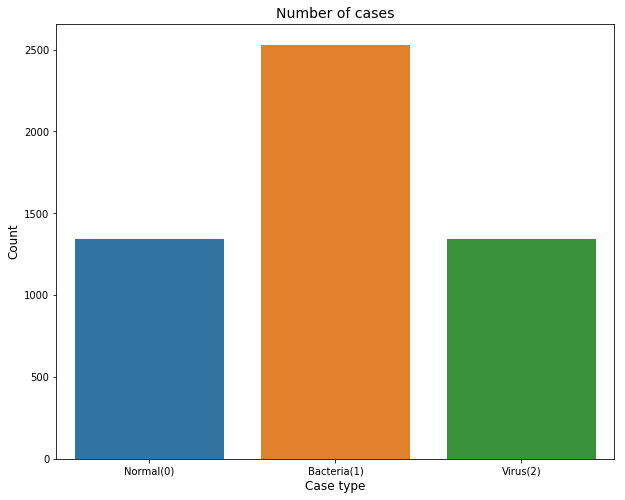

In [6]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Bacteria(1)', 'Virus(2)'])
plt.show()

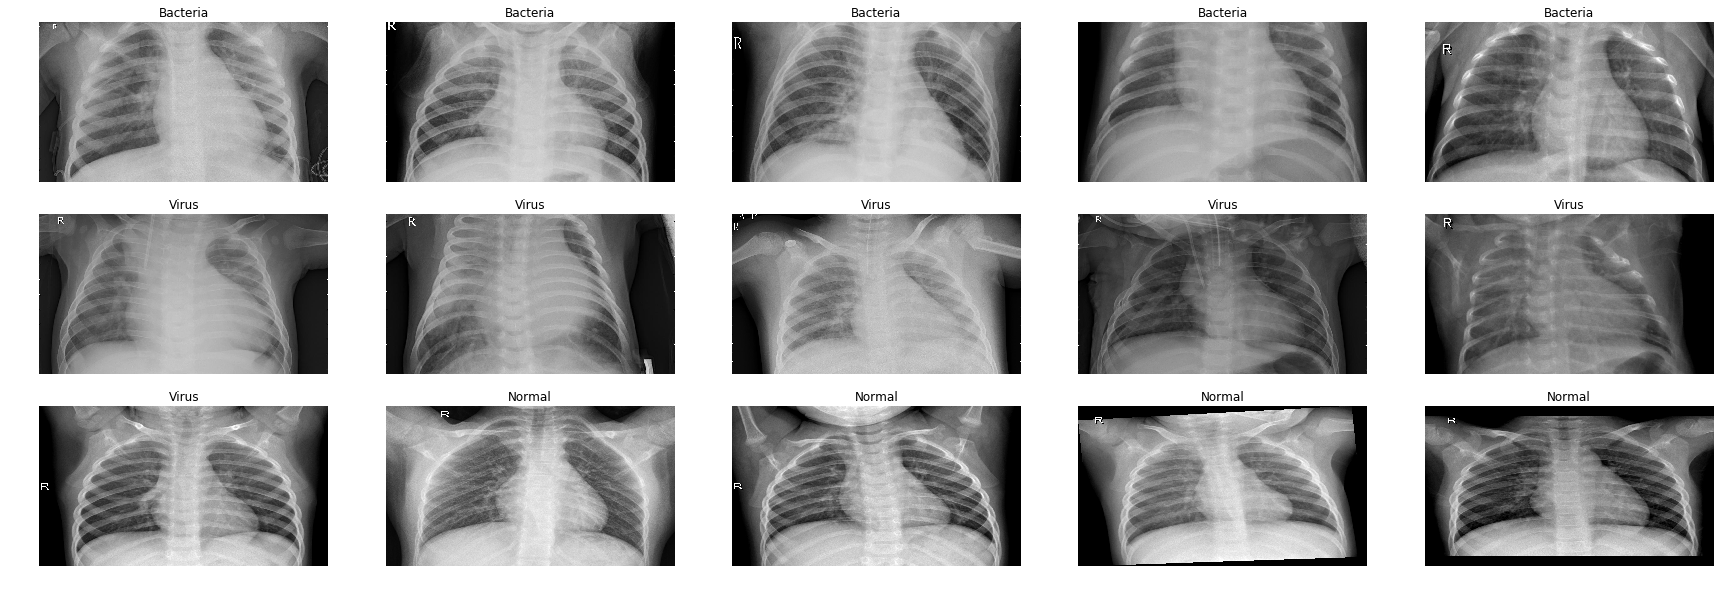

In [7]:
# Get few samples for both the classes
virus_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()
bacteria_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = virus_samples + bacteria_samples + normal_samples
del virus_samples, bacteria_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,10))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Bacteria")
    elif i>10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Virus")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()
# # Plot the data 
# f, ax = plt.subplots(3,3, figsize=(30,20))
# for i in range(9):
#     img = imread(samples[i])
#     ax[i//3, i%3].imshow(img, cmap='gray')
#     if i<3:
#         ax[i//3, i%3].set_title("Virus")
#     if 3<i<6:
#         ax[i//3, i%3].set_title("Bacteria")
#     if 6<i<9:
#         ax[i//3, i%3].set_title("Normal")
#     ax[i//3, i%3].axis('off')
#     ax[i//3, i%3].set_aspect('auto')
# plt.show()

In [8]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
# pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
bacteria_cases = pneumonia_cases_dir.glob('*_bacteria_*.jpeg')
virus_cases = pneumonia_cases_dir.glob('*_virus_*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=3)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Bac-Pneumonia cases        
for img in bacteria_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=3)
    valid_data.append(img)
    valid_labels.append(label)
    
# Vir-Pneumonia cases        
for img in virus_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=3)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 3)


In [9]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [10]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,3), dtype=np.float32) #2->3

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=3)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-1:
                aug_img1 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                count +=1
                        
            elif label==2 and count < batch_size-1:
                aug_img1 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                count +=1
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [11]:
# def build_model():
#     input_img = Input(shape=(224,224,3), name='ImageInput')
#     x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img) #64个layers3*3的kernel，convolute
#     x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x) 
#     x = MaxPooling2D((2,2), name='pool1')(x) #压缩图片
    
#     x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
#     x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
#     x = MaxPooling2D((2,2), name='pool2')(x)
    
#     x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
#     x = BatchNormalization(name='bn1')(x)
#     x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
#     x = BatchNormalization(name='bn2')(x)
#     x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
#     x = MaxPooling2D((2,2), name='pool3')(x)
    
#     x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
#     x = BatchNormalization(name='bn3')(x)
#     x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
#     x = BatchNormalization(name='bn4')(x)
#     x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
#     x = MaxPooling2D((2,2), name='pool4')(x)
    
#     x = Flatten(name='flatten')(x)
#     x = Dense(1024, activation='relu', name='fc1')(x)
#     x = Dropout(0.7, name='dropout1')(x)
#     x = Dense(512, activation='relu', name='fc2')(x)
#     x = Dropout(0.5, name='dropout2')(x)
#     x = Dense(3, activation='softmax', name='fc3')(x) #2
    
#     model = Model(inputs=input_img, outputs=x)
#     return model

In [12]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img) #64个layers3*3的kernel，convolute
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1_2')(x) 
    x = MaxPooling2D((2,2), name='pool1')(x) #压缩图片
    
    x = SeparableConv2D(64, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(64, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(3, activation='softmax', name='fc3')(x) #2
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [13]:
model =  build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 32)      896       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 32)      9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 64)      2400      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 64)      4736      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 64)        0         
__________

In [14]:
# Open the VGG16 weight file
f = h5py.File('vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 32)      896       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 32)      9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 64)      2400      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 64)      4736      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 64)        0         
__________

In [15]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5) #lr=learning rate, decay: learning rate decay rate, adam learning function
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
# model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt) #metrics 衡量标准
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [16]:
train_data.shape

(5216, 2)

In [17]:
valid_data.shape

(16, 224, 224, 3)

In [18]:
batch_size = 20 #数越大越精确
nb_epochs = 10

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 260 and 16


In [19]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4, 2:1.0})

Epoch 1/10
260/260 [==============================] - 128s 492ms/step - loss: 0.6207 - acc: 0.4808 - val_loss: 1.4194 - val_acc: 0.1250
Epoch 2/10
260/260 [==============================] - 121s 464ms/step - loss: 0.4364 - acc: 0.6408 - val_loss: 0.9954 - val_acc: 0.4375
Epoch 3/10
260/260 [==============================] - 122s 471ms/step - loss: 0.3926 - acc: 0.6842 - val_loss: 1.0436 - val_acc: 0.5000
Epoch 4/10
260/260 [==============================] - 121s 464ms/step - loss: 0.3585 - acc: 0.7138 - val_loss: 1.1565 - val_acc: 0.5000
Epoch 5/10
260/260 [==============================] - 122s 469ms/step - loss: 0.3676 - acc: 0.7021 - val_loss: 0.8988 - val_acc: 0.5625
Epoch 6/10
260/260 [==============================] - 120s 463ms/step - loss: 0.3393 - acc: 0.7313 - val_loss: 1.3915 - val_acc: 0.5000
Epoch 7/10
260/260 [==============================] - 121s 464ms/step - loss: 0.3192 - acc: 0.7529 - val_loss: 1.2348 - val_acc: 0.4375
Epoch 8/10
260/260 [============================

In [20]:
# Load the model weights
# model.load_weights('xray_best_model/best_model.hdf5')

In [21]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
# pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
bacteria_cases = pneumonia_cases_dir.glob('*_bacteria_*.jpeg')
virus_cases = pneumonia_cases_dir.glob('*_virus_*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=3)
    test_data.append(img)
    test_labels.append(label)
                      
# for img in pneumonia_cases:
#     img = cv2.imread(str(img))
#     img = cv2.resize(img, (224,224))
#     if img.shape[2] ==1:
#         img = np.dstack([img, img, img])
#     else:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32)/255.
#     label = to_categorical(1, num_classes=2)
#     test_data.append(img)
#     test_labels.append(label)
    
# Bac-Pneumonia cases        
for img in bacteria_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=3)
    test_data.append(img)
    test_labels.append(label)
    
# Vir-Pneumonia cases        
for img in virus_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=3)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 3)


In [22]:
test_labels.shape

(624, 3)

In [23]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 3s 5ms/step
Loss on test set:  1.02836593833
Accuracy on test set:  0.733974358974


In [24]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


In [25]:
cm  = confusion_matrix(orig_test_labels, preds)
cm

array([[109,  22, 103],
       [  3, 220,  19],
       [  1,  18, 129]], dtype=int64)

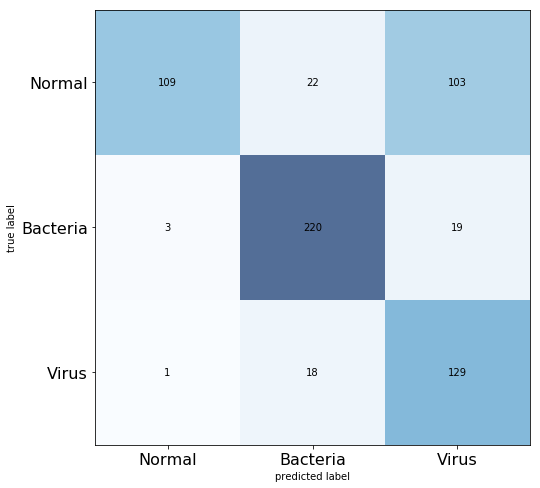

In [26]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, alpha=0.7,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Bacteria', 'Virus'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Bacteria', 'Virus'], fontsize=16)
plt.show()

In [27]:
cm[0][0]

109

In [28]:
tn = cm[0][0]
fn = cm[0][1]+cm[0][2]
tb = cm[1][1]
fb = cm[1][0]+cm[1][2]
tv = cm[2][2]
fv = cm[2][0]+cm[2][1]

In [29]:
# Calculate Precision and Recall
# tn, fb, fn, tb = cm.ravel()

recall = (tb+tv)/(tb+fb+tv+fv)
precision = (tb+tv)/(tb+tv+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.89
Precision of the model is 0.74


In [34]:
import keras
tb_cb = keras.callbacks.TensorBoard(log_dir='C:/Users/Emmet Zhao/AED_DEMO/7390/Project', write_images=1, histogram_freq=1) 

<img src="png.png">